# Erythroid pseudotime

In [1]:
options(warn=-1)

In [2]:
library_load <- suppressMessages(
    
    list(
        
        # Seurat 
        library(Seurat), 
        
        # Condiment
        library(condiments), 
        library(tradeSeq), 
        library(SingleCellExperiment), 
        
        # GO 
        library(msigdbr), 
        library(fgsea), 
        
        # Data 
        library(tidyverse), 
        library(openxlsx), 
        
        # Plotting 
        library(ComplexHeatmap), 
        library(circlize), 
        library(viridis), 
        library(ggplotify), 
        library(ComplexUpset), 
        
        # Prallel 
        library(BiocParallel), 
        
        # Python 
        library(reticulate)
        
    )
    
)

In [3]:
random_seed <- 42
set.seed(random_seed)

In [4]:
ht_opt$message=FALSE # ComplexHeatmap 

In [5]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [6]:
# Source files
source("plotting_global.R")
source("bin/tradeseq.R")
source("bin/seurat_qc.R")
source("bin/pbDEA.R")
source("bin/cell_type.R")

In [7]:
# Plotting Theme
ggplot2::theme_set(theme_global_set(size_select=1)) # From project global source()

# Set parallel 

In [8]:
options(mc.cores=1, future.globals.maxSize=200000*1024^2)

In [9]:
# Prallel computing 
BPPARAM <- BiocParallel::bpparam()
BPPARAM <- MulticoreParam(workers=future::availableCores())  

# Parameter settings and data import 

In [10]:
# Seurat object 
so <- readRDS("data/object/pp.rds")

# CellRank absorption probabilities 
absorption_probabilities_prog_nacl <- read.csv("result/cellrank/absorption_probabilities_prog_nacl.csv", row.names=1, check.names=FALSE)
absorption_probabilities_prog_cpg <- read.csv("result/cellrank/absorption_probabilities_prog_cpg.csv", row.names=1,check.names=FALSE)

# Prepare data subsets  

In [11]:
cell_type_prog=c(
    
    "MastP",
    "MegP", 
    "MEP (1)", 
    "MEP (2)", 
    "MEP (3)",
    "MEP (4)", 
    "ProEB (1)",
    "ProEB (2)",
    "ProEB (3)",
    "ProEB (4)",
    "EB (1)",
    "EB (2)",
    "EB (3)", 
    "EB (4)",
    "EB (5)"
    
)

In [12]:
so_prog <- subset(so, subset=cell_type_fine %in% cell_type_prog)
so_prog$treatment <- factor(so_prog$treatment, levels=names(color$treatment))
so_prog$cell_type_fine <- factor(so_prog$cell_type_fine, levels=cell_type_fine_order)

In [13]:
so_prog <- AddMetaData(so_prog, rbind(absorption_probabilities_prog_nacl, absorption_probabilities_prog_cpg))

In [14]:
so_prog_nacl <- subset(so_prog, subset=treatment=="NaCl")
so_prog_cpg <- subset(so_prog, subset=treatment=="CpG")

# Absorption probability box plots

Using treatment, cell_type_fine as id variables



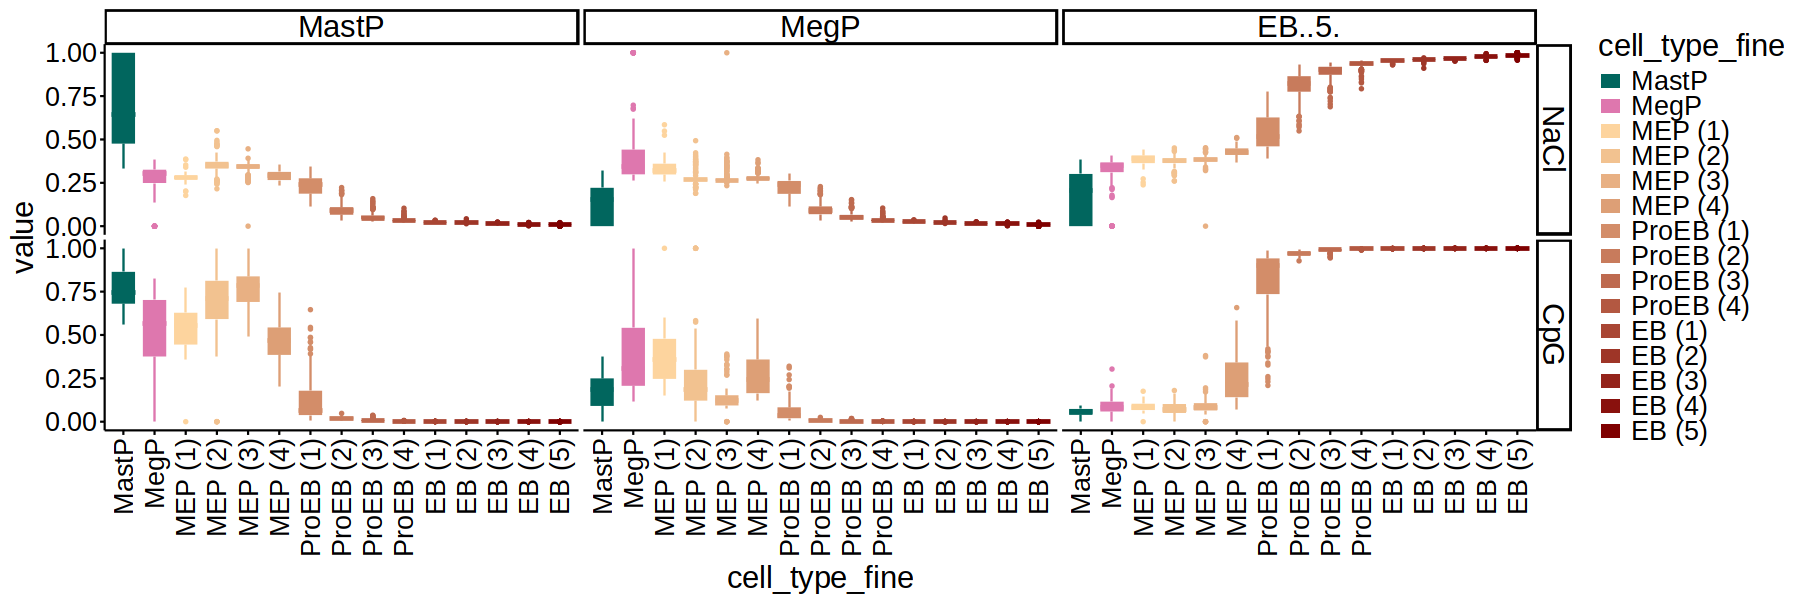

In [15]:
options(repr.plot.width=15, repr.plot.height=5)

data <- select(so_prog@meta.data, treatment, cell_type_fine, MastP, MegP, EB..5.) %>% 
    reshape2::melt(id_vars=c("treatment", "cell_type_fine")) %>% as.data.frame() %>% 
    dplyr::mutate(cell_type_fine=factor(cell_type_fine, levels=cell_type_prog)) %>% 
    dplyr::mutate(treatment=factor(treatment, levels=c("NaCl", "CpG")))

plot <- ggplot(data, aes(x=cell_type_fine, y=value, color=cell_type_fine, fill=cell_type_fine)) + 
    geom_boxplot(outlier.size=0.5) + 
    facet_grid(treatment~variable) + 
    scale_color_manual(values=color[["cell_type_fine_detail"]][names(color[["cell_type_fine_detail"]]) %in% so_prog$cell_type_fine]) + 
    scale_fill_manual(values=color[["cell_type_fine_detail"]][names(color[["cell_type_fine_detail"]]) %in% so_prog$cell_type_fine]) + 
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

plot

# Start point DEA

In [16]:
grouping_var="cell_type_fine"
pseudobatch_var="sample_group"

p_adj_thr=0.05
sample_weights=FALSE

In [17]:
results <- voomlmfit_marker(so=subset(so_prog, subset=cell_type_fine %in% c("MEP (1)", "MEP (2)", "MEP (3)", "MEP (4)")), grouping_var=grouping_var, pseudobatch_var=pseudobatch_var)

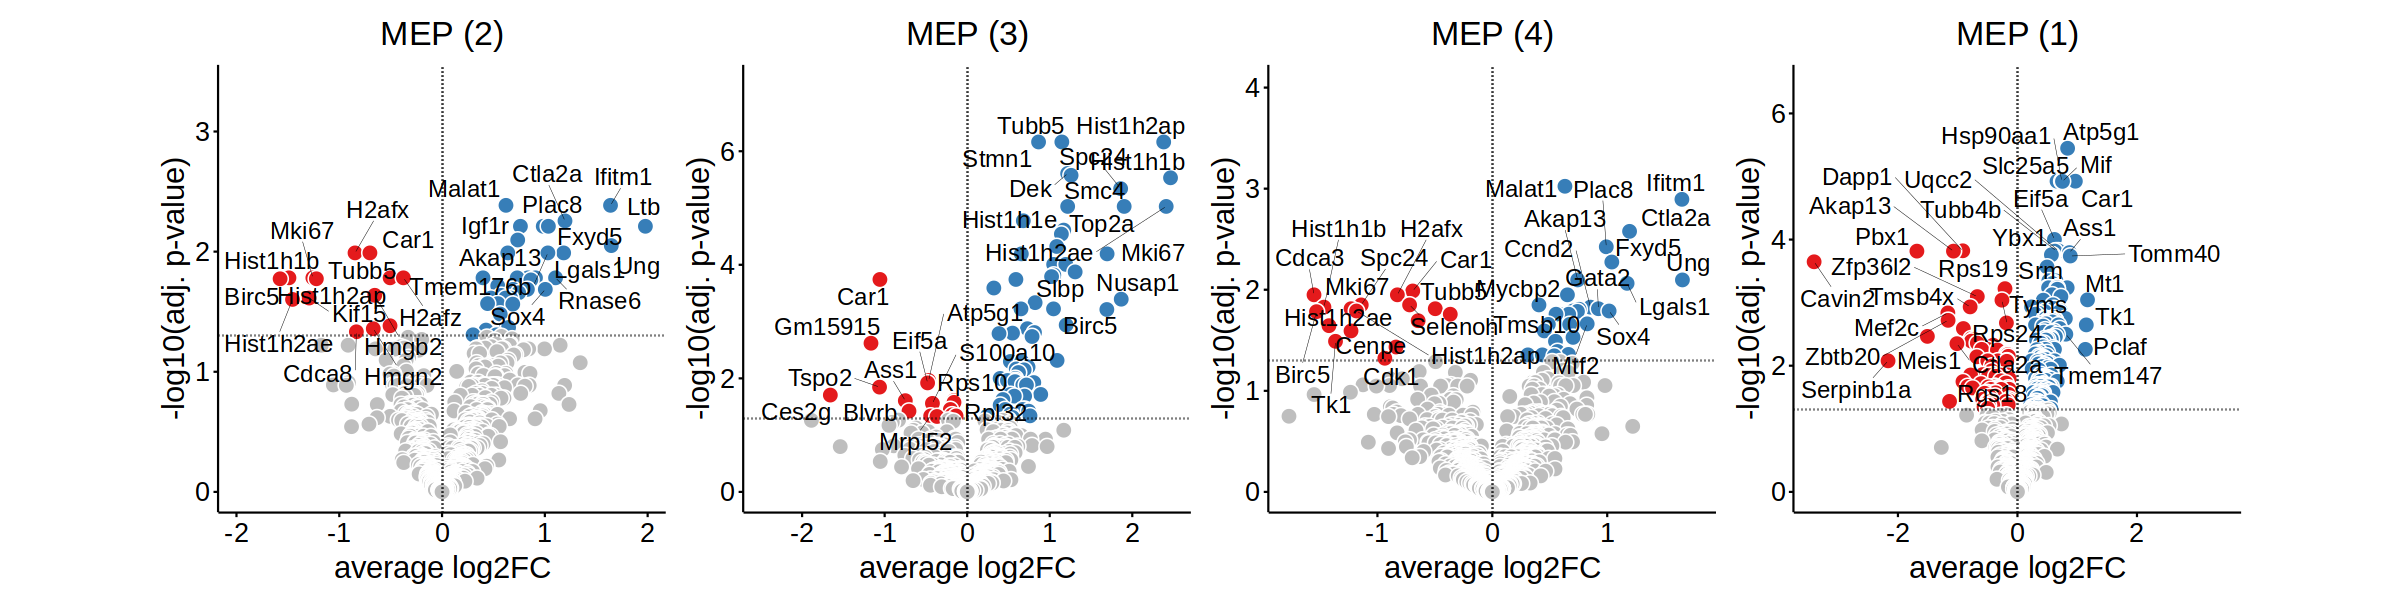

In [18]:
options(repr.plot.width=4*5, repr.plot.height=1*5)

vp <- lapply(names(results), function(i) {dea_vp(results[[i]], title=i, log2fc_thr=0, p_adj_thr=p_adj_thr)})
wrap_plots(vp, ncol=4, nrow=1)

# Endpoint DEA

In [19]:
grouping_var="cell_type_fine"
pseudobatch_var="sample_group"

p_adj_thr=0.05
sample_weights=FALSE

In [20]:
results <- voomlmfit_marker(so=subset(so_prog, subset=cell_type_fine %in% c("MastP", "MegP", "EB (5)")), grouping_var=grouping_var, pseudobatch_var=pseudobatch_var)

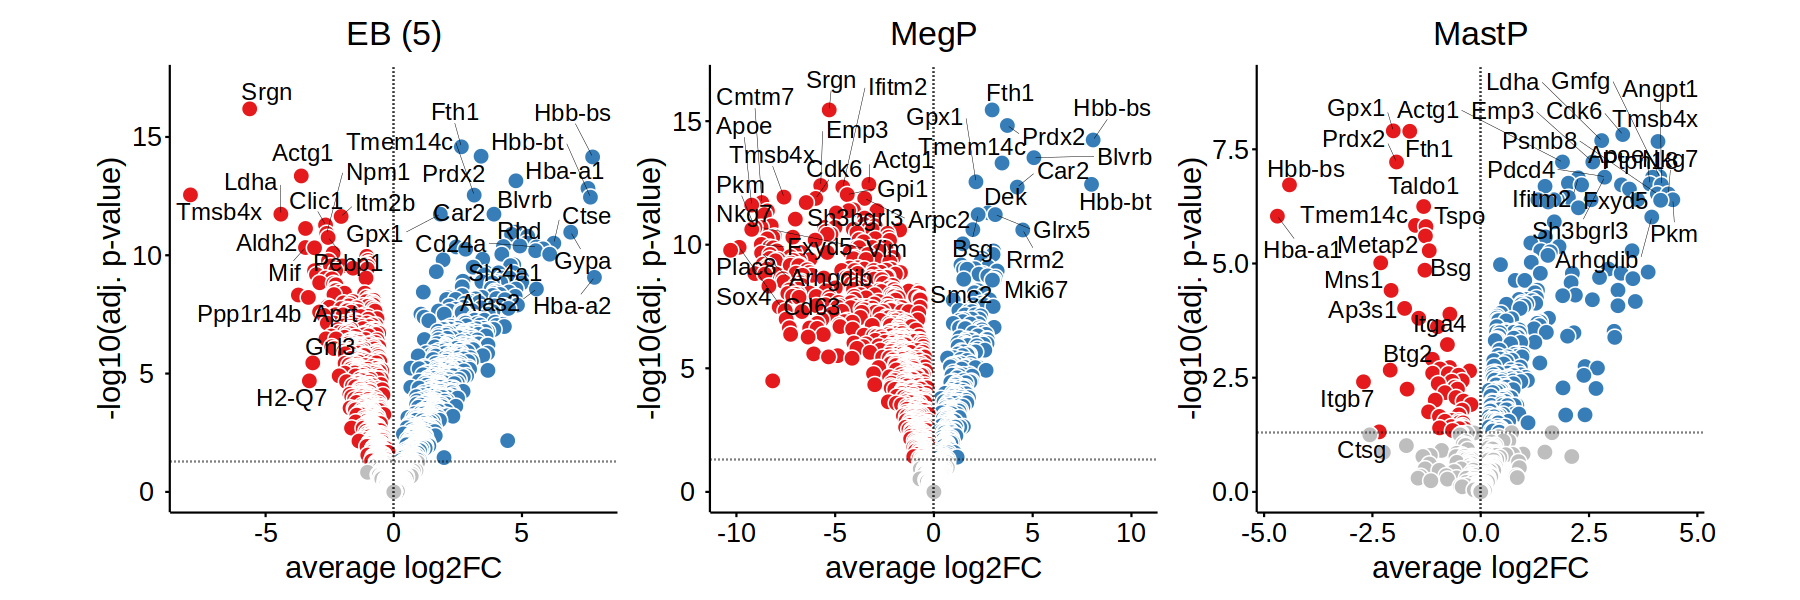

In [21]:
options(repr.plot.width=3*5, repr.plot.height=1*5)

vp <- lapply(names(results), function(i) {dea_vp(results[[i]], title=i, log2fc_thr=0, p_adj_thr=p_adj_thr)})
wrap_plots(vp, ncol=3, nrow=1)

# Condiment + Diffusion pseudotime 

In [22]:
pseudotime_density_plot <- function(so, pseudotime="dpt_pseudotime"){
    
    plot <- ggplot(so@meta.data, aes_string(x=pseudotime)) + 
        geom_density(alpha=0.8, aes(fill=treatment), color="transparent") + 
        geom_density(aes(col=treatment), fill="transparent", guide=FALSE, size=1.5) +
        labs(x="Pseudotime", fill="Treatment") +
        guides(color="none") +
        scale_color_manual(values=color[["treatment"]]) +
        scale_fill_manual(values=color[["treatment"]]) 

    return(plot)

}

## Prepare data

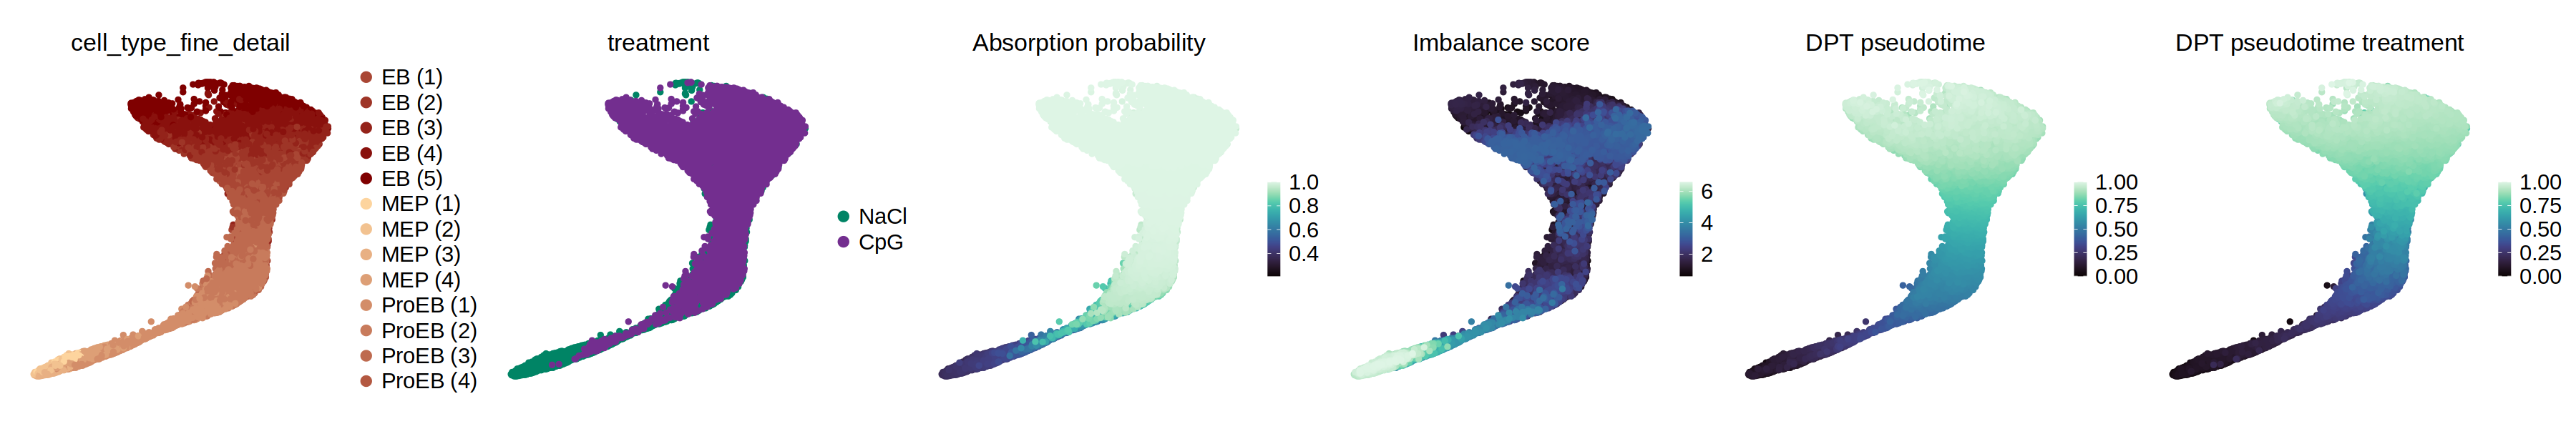

In [23]:
options(repr.plot.width=30, repr.plot.height=5)

so_eb <- suppressMessages(import_cellrank(so_prog, suffix="_eb", absorption_probability_col="EB..5."))

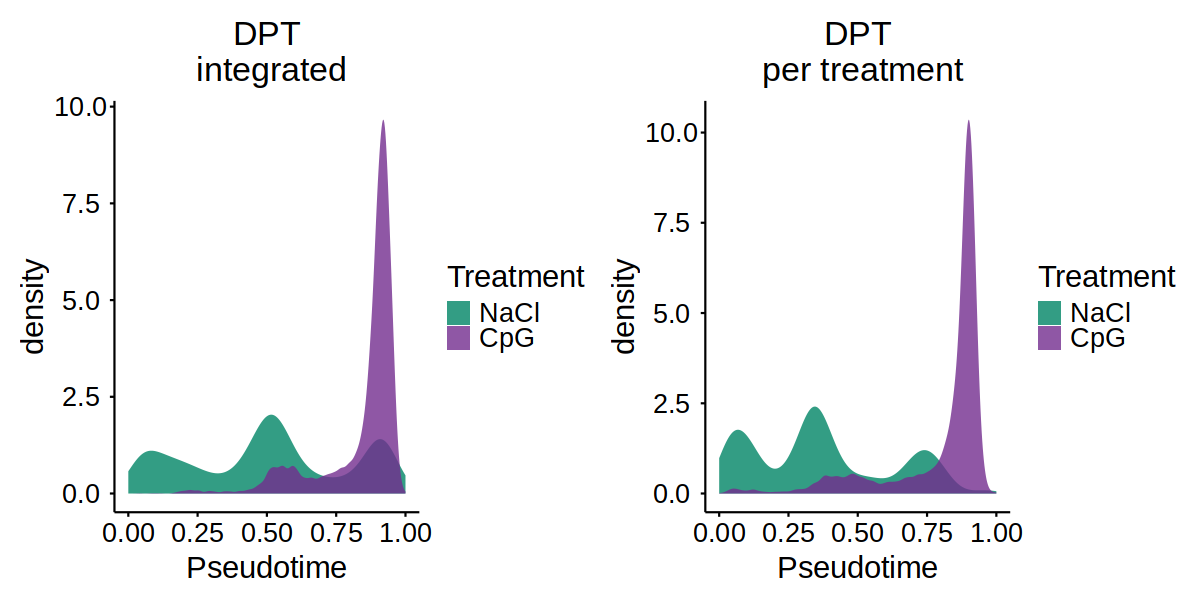

In [24]:
options(repr.plot.width=10, repr.plot.height=5)

pdp_1 <- pseudotime_density_plot(so_eb, pseudotime="dpt_pseudotime") + ggtitle("DPT\n integrated")
pdp_2 <- pseudotime_density_plot(so_eb, pseudotime="dpt_pseudotime_treatment") + ggtitle("DPT\n per treatment")

pdp_1 + pdp_2

## Scale pseudotime for each treatment group

In [25]:
dpt_pseudotime_nacl <- subset(so_eb, subset=treatment=="NaCl")@meta.data["dpt_pseudotime"]
dpt_pseudotime_nacl$dpt_pseudotime <- scales::rescale(dpt_pseudotime_nacl$dpt_pseudotime)

dpt_pseudotime_cpg <- subset(so_eb, subset=treatment=="CpG")@meta.data["dpt_pseudotime"]
dpt_pseudotime_cpg$dpt_pseudotime <- scales::rescale(dpt_pseudotime_cpg$dpt_pseudotime)

dpt_pseudotime <- rbind(dpt_pseudotime_nacl, dpt_pseudotime_cpg)

In [26]:
so_eb$dpt_pseudotime <- NULL
so_eb <- AddMetaData(so_eb, dpt_pseudotime)

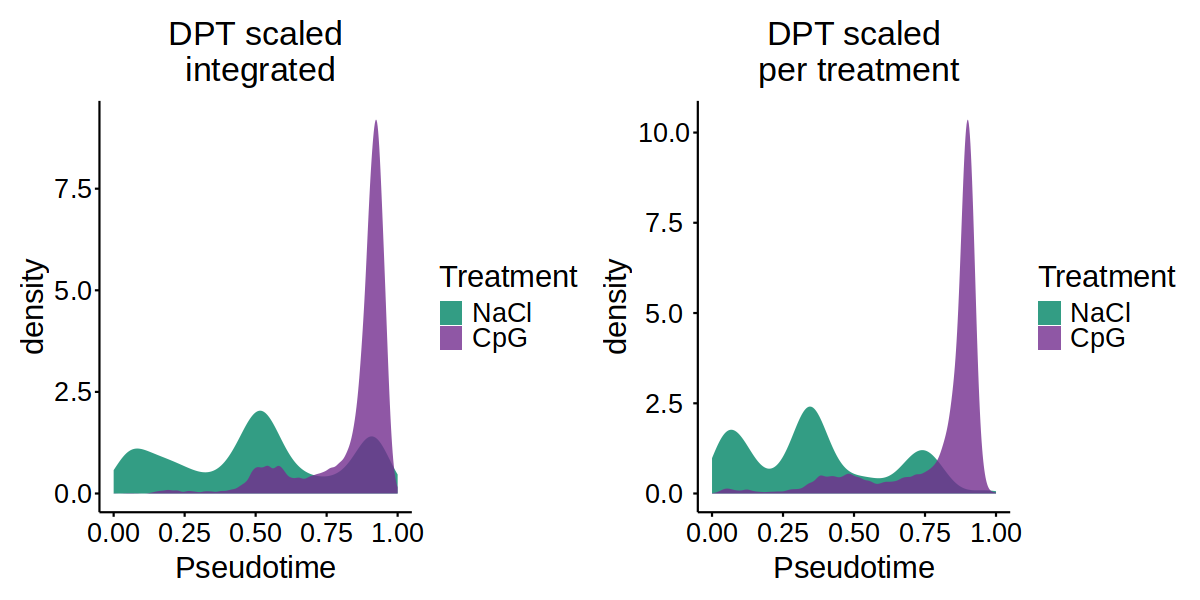

In [27]:
options(repr.plot.width=10, repr.plot.height=5)

pdp_1 <- pseudotime_density_plot(so_eb, pseudotime="dpt_pseudotime") + ggtitle("DPT scaled\n integrated")
pdp_2 <- pseudotime_density_plot(so_eb, pseudotime="dpt_pseudotime_treatment")+ ggtitle("DPT scaled\n per treatment")

pdp_1 + pdp_2

# Save pseudotime 

In [ ]:
write.csv(so_eb@meta.data[, "dpt_pseudotime", drop=FALSE], "result/tradeseq/dpt_pseudotime.csv")

# Select erythroid genes

In [ ]:
cnt_nacl <- GetAssayData(subset(so_eb, subset=treatment=="NaCl"), assay="RNA", slot="counts")
genes_nacl <- rownames(cnt_nacl[rowSums(cnt_nacl>=1)>=10, ])

In [ ]:
cnt_cpg <- GetAssayData(subset(so_eb, subset=treatment=="CpG"), assay="RNA", slot="counts")
genes_cpg <- rownames(cnt_cpg[rowSums(cnt_cpg>=1)>=10, ])

In [ ]:
genes <- unique(c(genes_nacl, genes_cpg))
genes <- genes[!genes=="Igkc"]

In [ ]:
write.csv(data.frame(genes=as.character(genes)), "result/tradeseq/genes.csv")